In [44]:
import pandas as pd
import numpy as np
import ftplib
import io
import re
import gzip
import subprocess
import collections
from matplotlib import pyplot as plt
from pathlib import Path
from Bio import SeqIO
from tqdm.notebook import tqdm

In [2]:
assembly_data = pd.read_csv('assemblies_students.csv', index_col=0)
target_assembly = assembly_data.loc['Сивков Антон Александрович'].tolist()

In [3]:
target_assembly

['ASM1382v1',
 'ASM1644v1',
 'ASM83433v1',
 'ASM83449v1',
 'ASM83500v1',
 'ASM97010v1',
 'ASM118893v1',
 'ASM129341v1',
 'ASM929598v1',
 'ASM929600v1']

In [4]:
assembly_data_paths = {
    'ASM1382v1': 'genomes/all/GCA/000/013/825/GCA_000013825.1_ASM1382v1/',
    'ASM1644v1': 'genomes/all/GCA/000/016/445/GCA_000016445.1_ASM1644v1/',
    'ASM83433v1': 'genomes/all/GCA/000/834/335/GCA_000834335.1_ASM83433v1/',
    'ASM83449v1': 'genomes/all/GCA/000/834/495/GCA_000834495.1_ASM83449v1/',
    'ASM83500v1': 'genomes/all/GCA/000/835/005/GCA_000835005.1_ASM83500v1/',
    'ASM97010v1': 'genomes/all/GCA/000/970/105/GCA_000970105.1_ASM97010v1/',
    'ASM118893v1': 'genomes/all/GCA/001/188/935/GCA_001188935.1_ASM118893v1/',
    'ASM129341v1': 'genomes/all/GCA/001/293/415/GCA_001293415.1_ASM129341v1/',
    'ASM929598v1': 'genomes/all/GCA/009/295/985/GCA_009295985.1_ASM929598v1/',
    'ASM929600v1': 'genomes/all/GCA/009/296/005/GCA_009296005.1_ASM929600v1/'
}

In [5]:
ftp_server = ftplib.FTP('ftp.ncbi.nlm.nih.gov')
ftp_server.login()
for sample_id, data_path in tqdm(assembly_data_paths.items()):
    file_list = ftp_server.nlst(data_path)
    target_path = next(item for item in ftp_server.nlst(data_path) if item.endswith(f'{sample_id}_genomic.fna.gz'))
    buffer = io.BytesIO()
    ftp_server.retrbinary(f'RETR {target_path}', buffer.write)
    buffer.seek(0)
    with open(f'{sample_id}.fna', 'wb') as output_d, gzip.open(buffer) as input_gzip:
        output_d.write(input_gzip.read())

### 0

In [6]:
fasta_without_plasmids = dict()
for file in Path('.').glob('*v1.fna'):
    records = [next(SeqIO.parse(file, 'fasta'))]
    result_path = Path(f"{file.stem}-no-plasmids.fna")
    with result_path.open('w') as output_d:
        SeqIO.write(records, output_d, 'fasta')
    fasta_without_plasmids[file.stem] = result_path

In [8]:
fasta_without_plasmids

{'ASM929600v1': PosixPath('ASM929600v1-no-plasmids.fna'),
 'ASM97010v1': PosixPath('ASM97010v1-no-plasmids.fna'),
 'ASM83449v1': PosixPath('ASM83449v1-no-plasmids.fna'),
 'ASM83433v1': PosixPath('ASM83433v1-no-plasmids.fna'),
 'ASM1382v1': PosixPath('ASM1382v1-no-plasmids.fna'),
 'ASM929598v1': PosixPath('ASM929598v1-no-plasmids.fna'),
 'ASM1644v1': PosixPath('ASM1644v1-no-plasmids.fna'),
 'ASM118893v1': PosixPath('ASM118893v1-no-plasmids.fna'),
 'ASM129341v1': PosixPath('ASM129341v1-no-plasmids.fna'),
 'ASM83500v1': PosixPath('ASM83500v1-no-plasmids.fna')}

### 1

In [9]:
output_paths = {1000: Path('1000min_sibelia_result'), 5000: Path('5000min_sibelia_result')}
for value in output_paths.values():
    value.mkdir()

In [10]:
for threshold, result_dir in tqdm(output_paths.items()):
    subprocess.run([
        'Sibelia-2.1.1-Darwin/bin/Sibelia',
        '-s',
        'fine',
        '-m',
        str(threshold),
        '-o', 
        str(result_dir),
        *map(str, fasta_without_plasmids.values())
    ], check=True)

### 2

In [16]:
def parse_blocks_data(data_path):
    result = dict()
    with open(data_path) as input_d:
        raw_data = re.split('-{2,}', input_d.read())
    sequence_data = pd.read_csv(io.StringIO(raw_data[0]), sep='\t', index_col=0)
    block_hits = dict()
    for str_data in tqdm(raw_data[1:-1]):
        block_hits[int(re.search('^\nBlock #(\d+)\n', str_data, flags=re.MULTILINE).group(1))] = pd.read_csv(
            io.StringIO(str_data), sep='\t', skiprows=[0, 1], index_col=0
        )
    return {'sequence_data': sequence_data, 'block_hits': block_hits}

In [17]:
result_blocks_data = dict()
for key, data_path in output_paths.items():
    result_blocks_data[key] = parse_blocks_data(Path(data_path, 'blocks_coords.txt'))

In [23]:
blocks_by_sample = dict()
for threshold, threshold_data in result_blocks_data.items():
    tmp_data = collections.defaultdict(set)
    for block, block_data in threshold_data['block_hits'].items():
        for seq_id in block_data.index.unique():
            tmp_data[seq_id].add(block)
    blocks_by_sample[threshold] = dict(tmp_data)

Text(0.5, 1.0, 'repeated blocks')

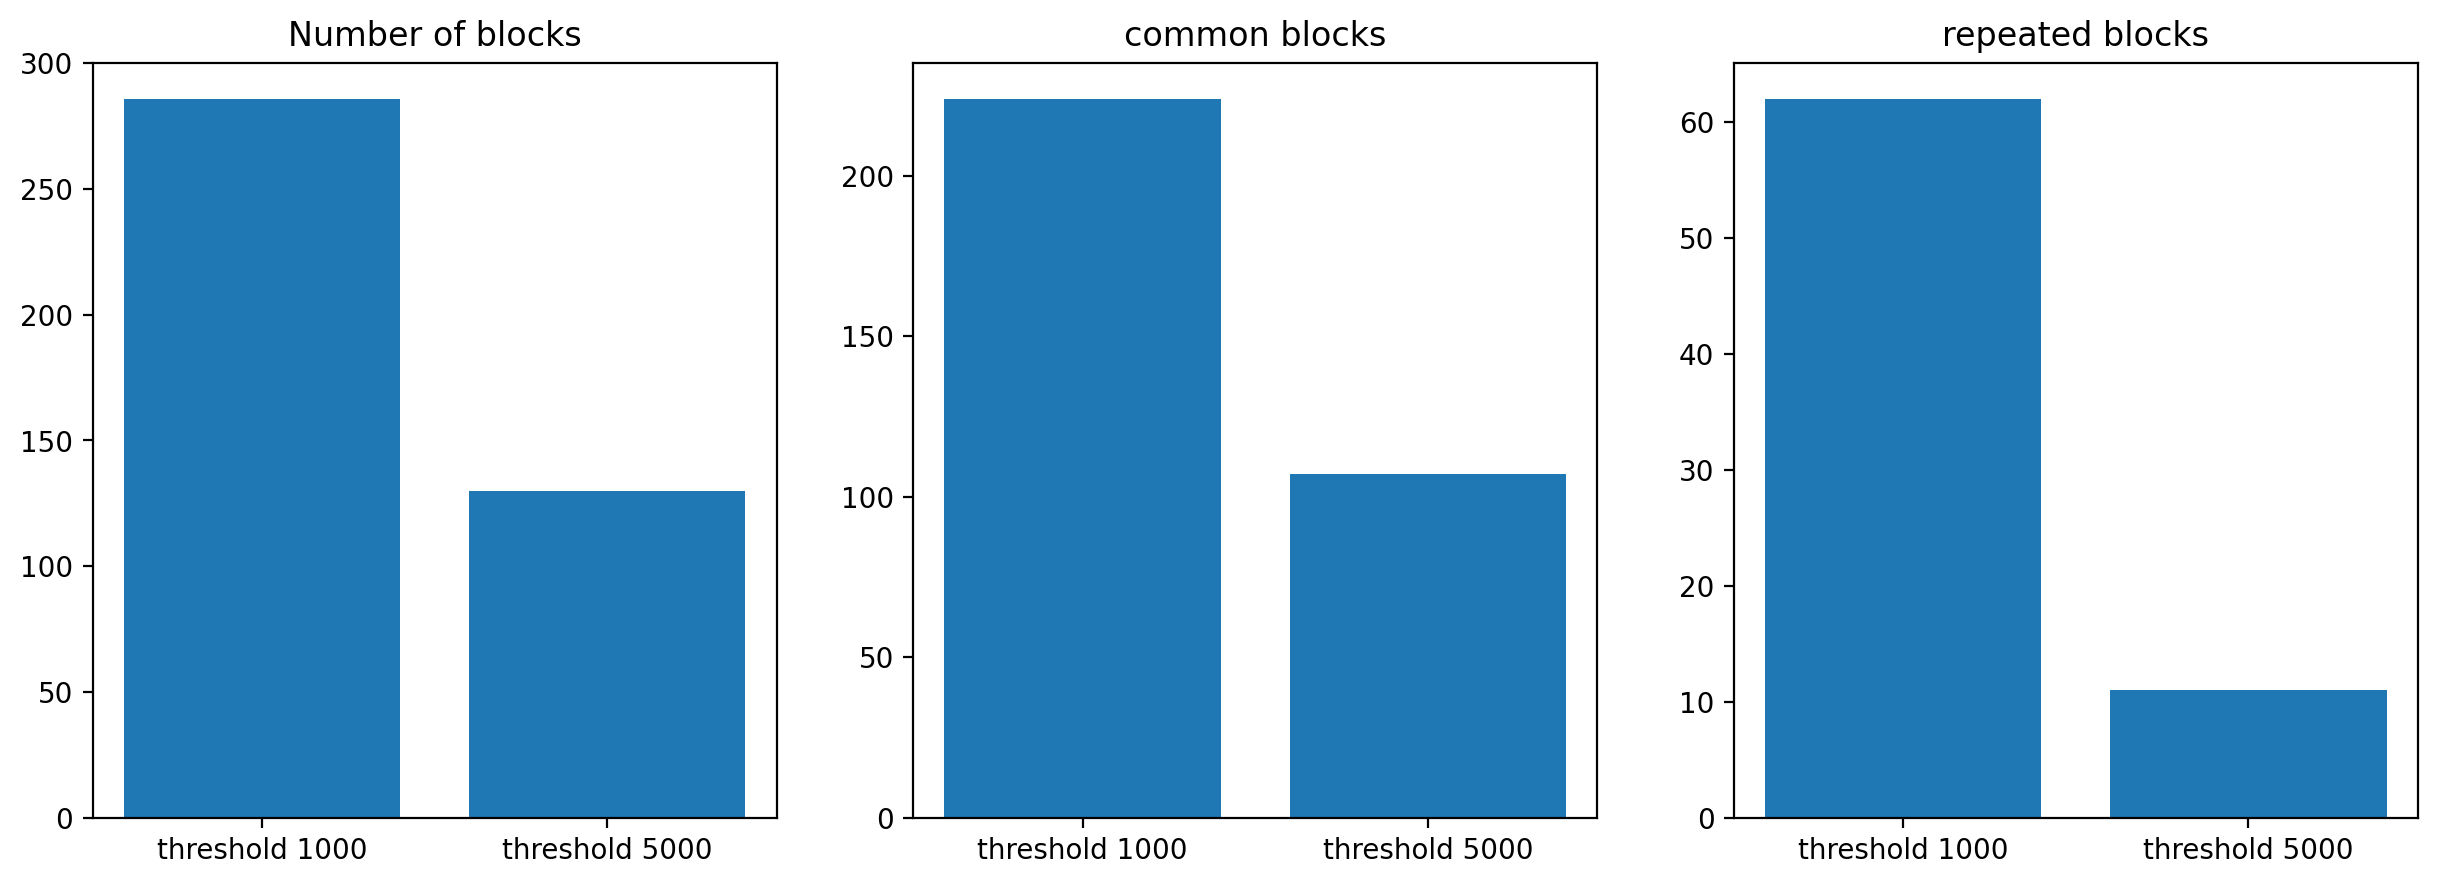

In [32]:
_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), dpi=200)
axes[0].bar([0, 1], [len(result_blocks_data[1000]['block_hits']), len(result_blocks_data[5000]['block_hits'])])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['threshold 1000', 'threshold 5000'])
axes[0].set_title('Number of blocks')
common_sets = {
    1000: set.intersection(*blocks_by_sample[1000].values()), 5000: set.intersection(*blocks_by_sample[5000].values())
}
axes[1].bar([0, 1], [len(common_sets[1000]), len(common_sets[5000])])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['threshold 1000', 'threshold 5000'])
axes[1].set_title('common blocks')
axes[2].bar(
    [0, 1], 
    [len(set.union(*blocks_by_sample[1000].values()).difference(common_sets[1000])), 
     len(set.union(*blocks_by_sample[5000].values()).difference(common_sets[1000]))]
)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['threshold 1000', 'threshold 5000'])
axes[2].set_title('repeated blocks')

### 3

In [38]:
block_length = {key: value['Length'].mean() for key, value in result_blocks_data[1000]['block_hits'].items()}
block_freq = {key: value.shape[0] for key, value in result_blocks_data[1000]['block_hits'].items()}

Text(0.5, 0, 'log10 block frequency')

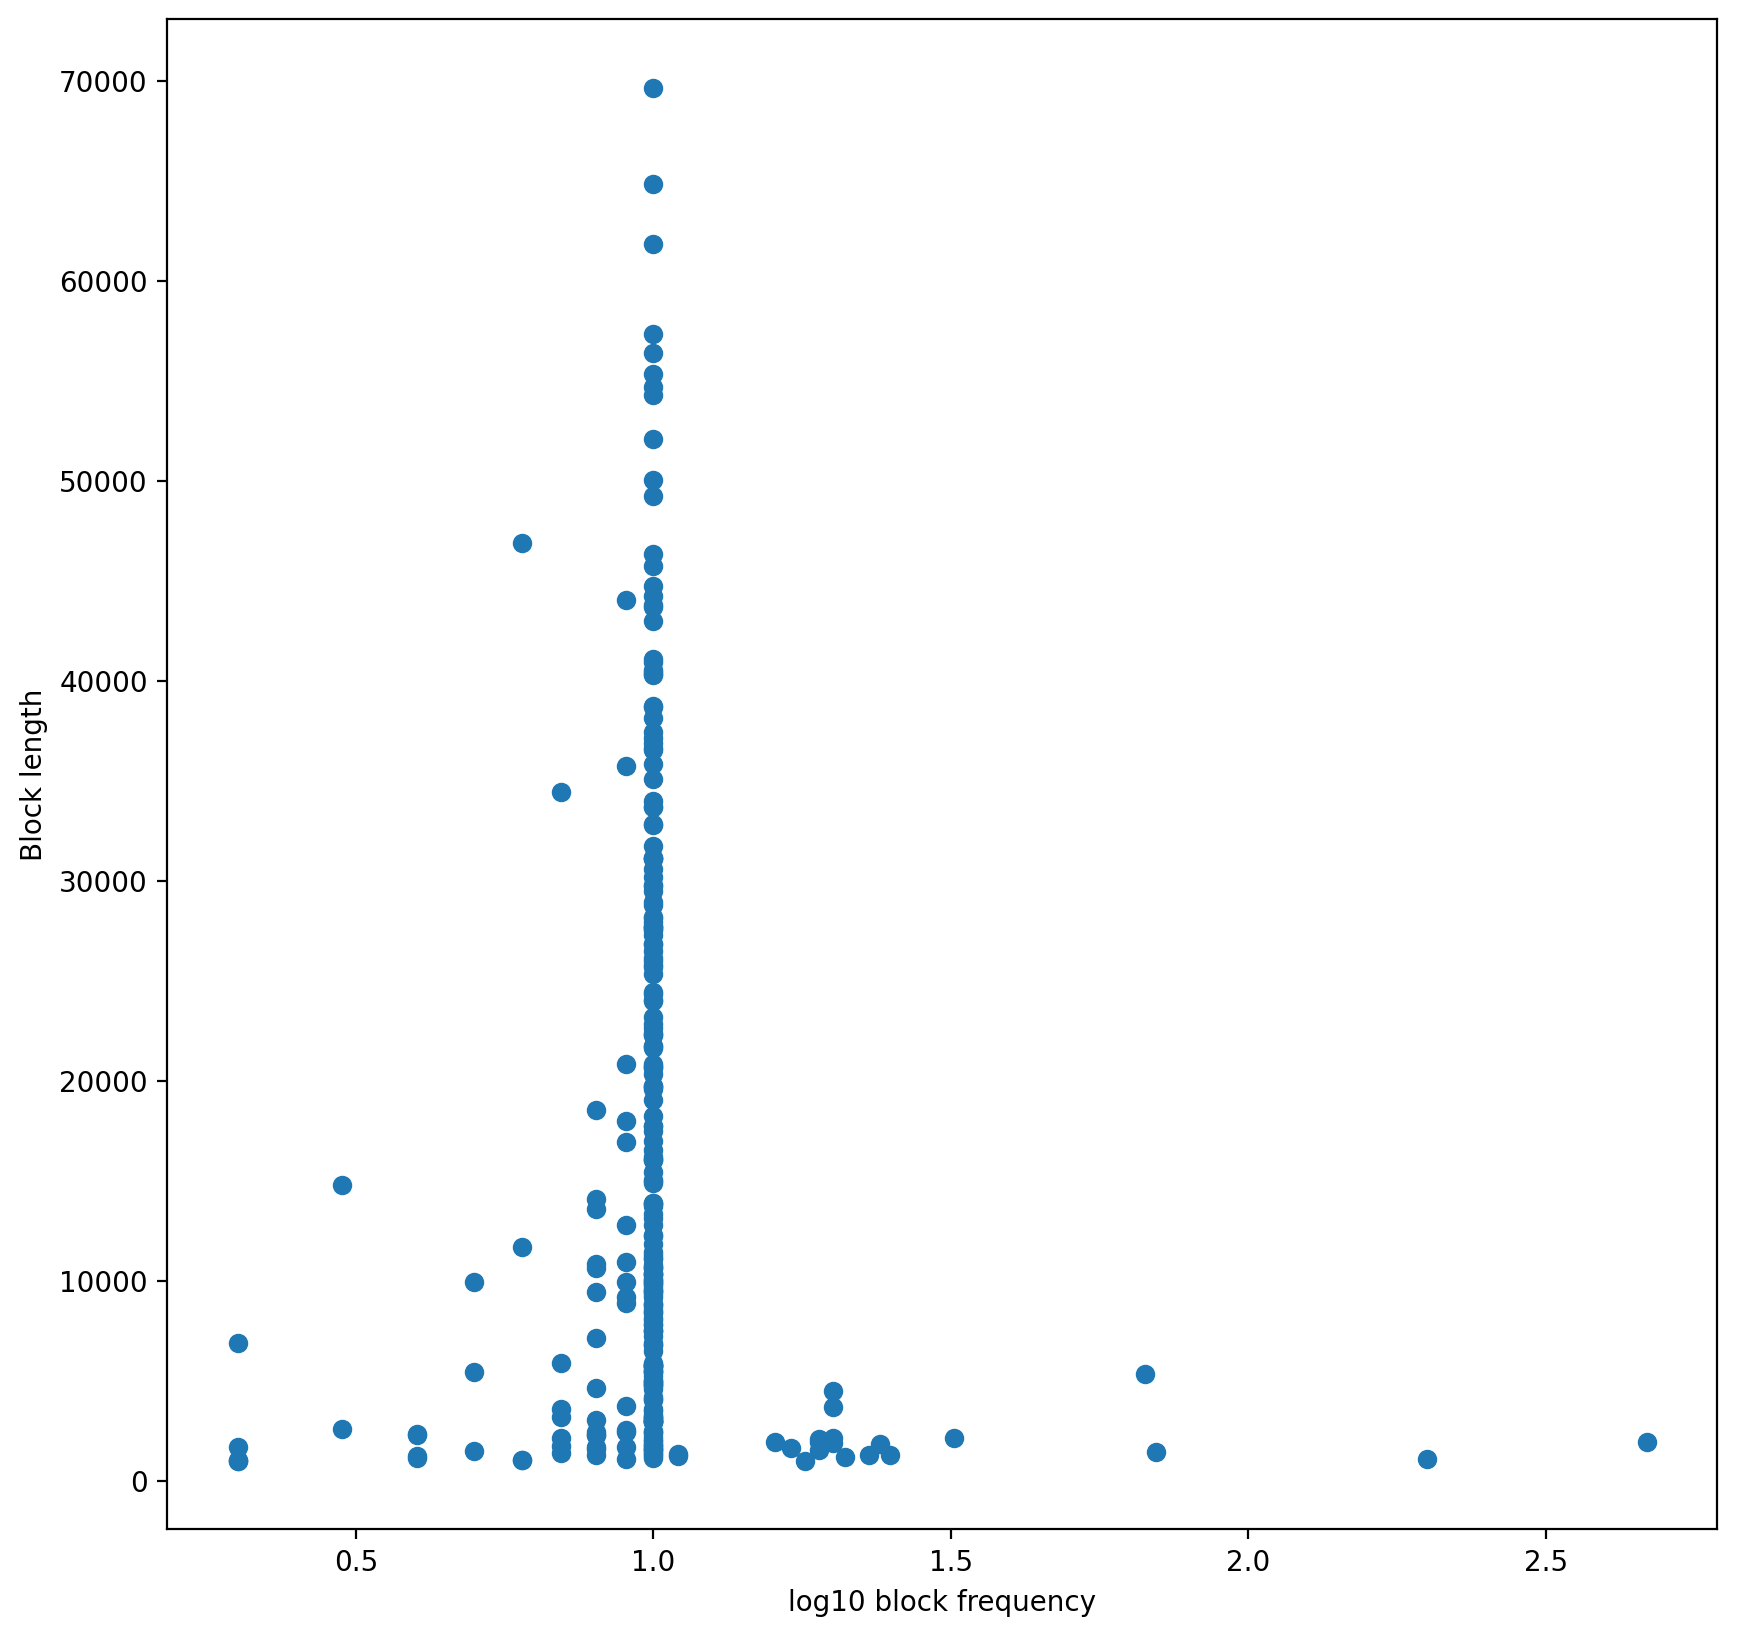

In [47]:
_, ax = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(10, 10))
ax.scatter(np.log10(list(block_freq.values())), block_length.values())
ax.set_ylabel('Block length')
ax.set_xlabel('log10 block frequency')

### 4

In [59]:
block_hits = collections.defaultdict(set)
for sample, blocks in blocks_by_sample[1000].items():
    for block in blocks:
        block_hits[block].add(sample)
block_hits = dict(block_hits)
rare_blocks = {key for key, value in block_hits.items() if len(value) == 2}

In [62]:
longest_common_block = max(
    ((block, length) for block, length in block_length.items() if block in common_sets[1000]), key=lambda x: x[1]
)[0]
longest_rare_block = max(
    ((block, length) for block, length in block_length.items() if block in rare_blocks), key=lambda x: x[1]
)[0]

In [83]:
result_blocks_data[1000]['block_hits'][longest_rare_block]

,Strand,Start,End,Length
Seq_id,,,,
7,+,3268349,3275235,6887
8,+,1488256,1495142,6887


In [84]:
result_blocks_data[1000]['block_hits'][longest_common_block]

,Strand,Start,End,Length
Seq_id,,,,
1,+,3548446,3618066,69621
2,+,527552,597180,69629
3,-,1904773,1835155,69619
4,-,170963,101344,69620
5,+,3190282,3259857,69576
6,-,804664,734977,69688
7,-,3397156,3327511,69646
8,-,2808112,2738434,69679
9,-,3725850,3656231,69620


take 7 (CP000668.1) sequence to extract genes

In [93]:
record = next(SeqIO.parse('CP000668.1.gb', 'genbank'))

longest common block

In [125]:
target_features = [
    item for item in records[0].features 
    if item.location.start > 3327511 and item.location.end < 3397156 and item.type == 'gene' and item.strand == -1
]

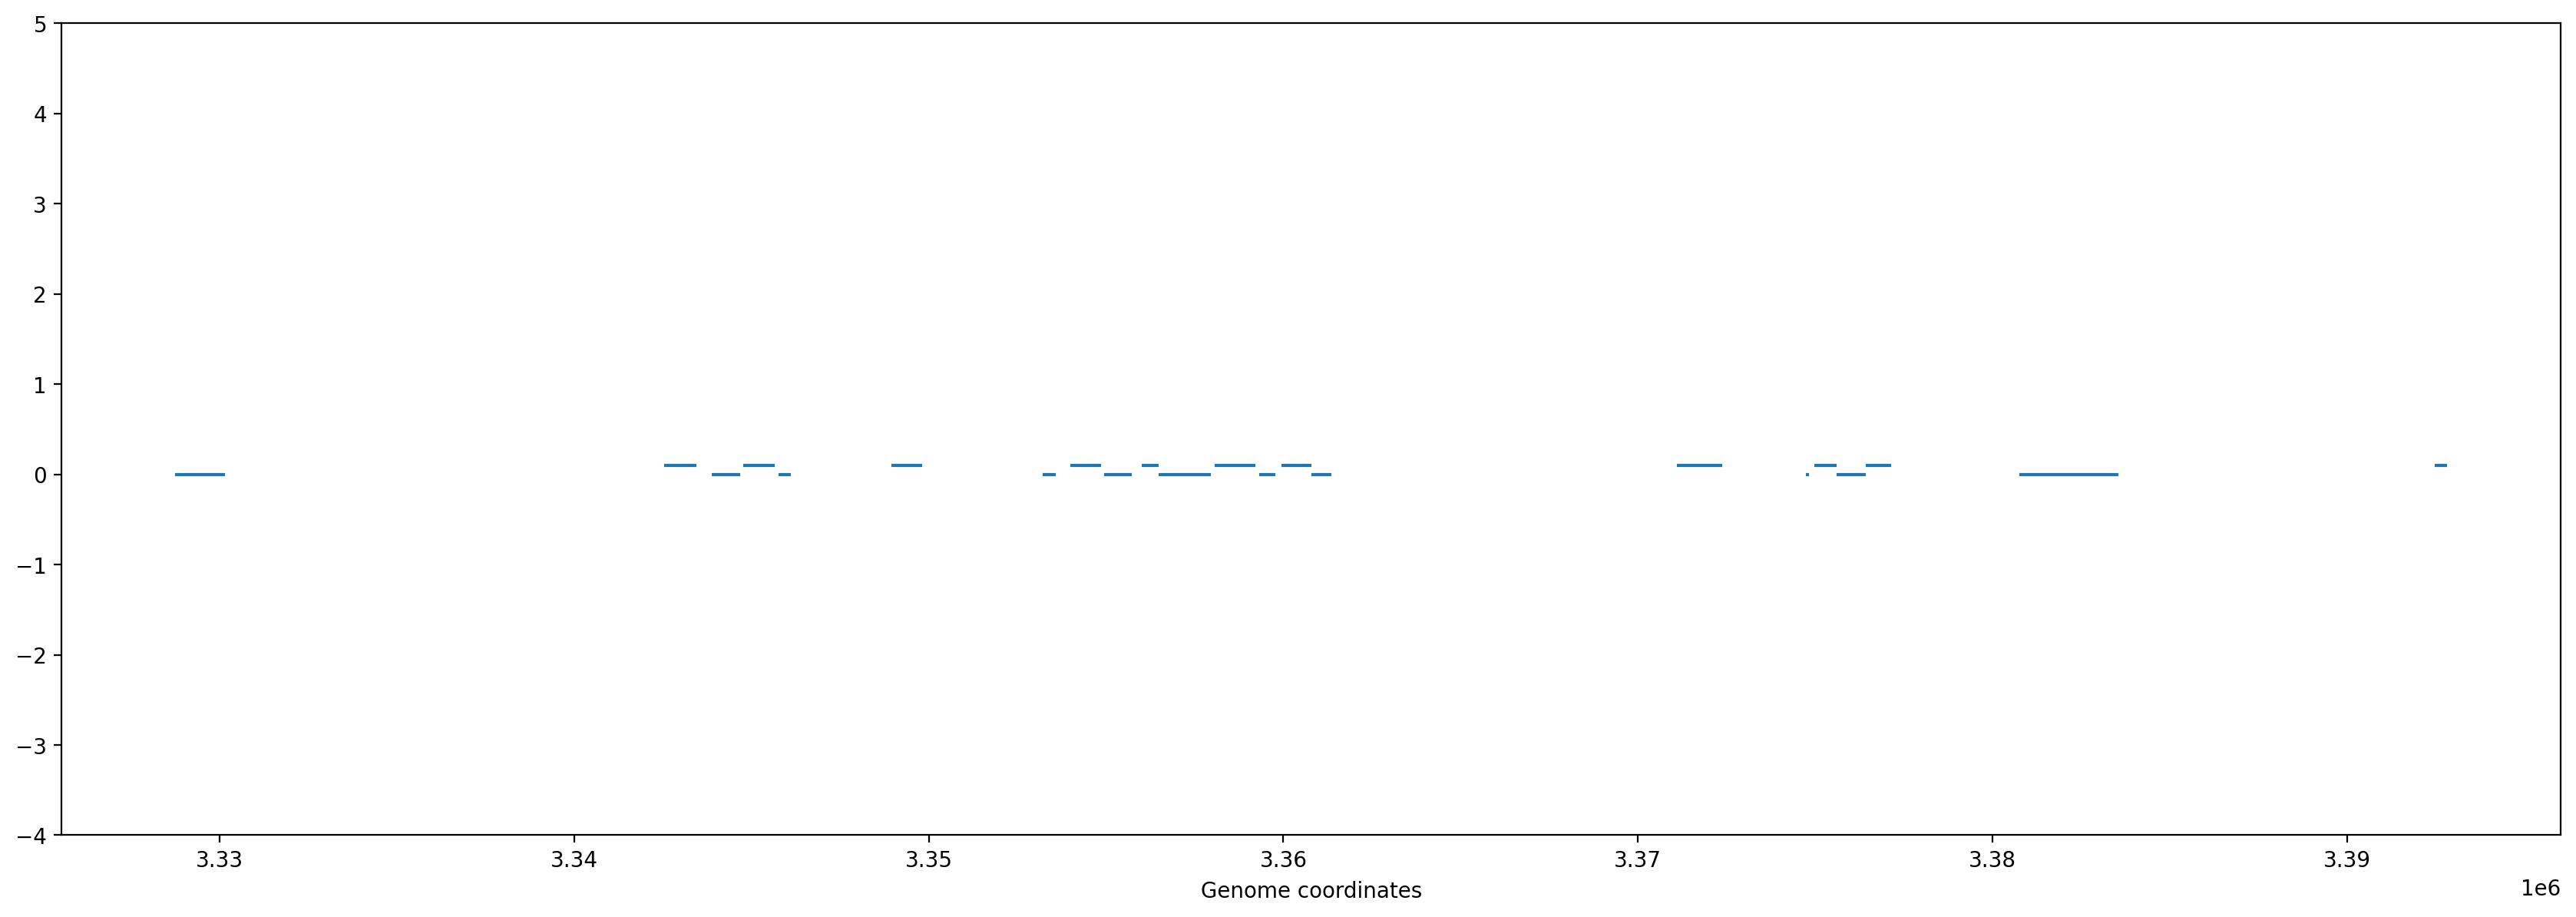

In [135]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(21, 7), dpi=200)
for i, feature in enumerate(target_features):
    ax.hlines(i % 2 / 10, feature.location.start, feature.location.end)
    ax.set_ylim(-4, 5)
    ax.set_xlabel('Genome coordinates')

Нарисовал в "шахматном порядке" для визуализации, можно явно выделить 3 оперона (остальные сегменты из одного гена)

In [136]:
[feature.qualifiers['locus_tag'][0] for feature in target_features]

['YPDSF_2933',
 'YPDSF_2942',
 'YPDSF_2943',
 'YPDSF_2944',
 'YPDSF_2945',
 'YPDSF_2948',
 'YPDSF_2953',
 'YPDSF_2954',
 'YPDSF_2955',
 'YPDSF_2956',
 'YPDSF_2957',
 'YPDSF_2958',
 'YPDSF_2959',
 'YPDSF_2960',
 'YPDSF_2961',
 'YPDSF_2968',
 'YPDSF_2971',
 'YPDSF_2972',
 'YPDSF_2973',
 'YPDSF_2974',
 'YPDSF_2977',
 'YPDSF_2986']

longest rare block

In [137]:
target_features = [
    item for item in records[0].features 
    if item.location.start > 3268349 and item.location.end < 3275235 and item.type == 'gene' and item.strand == 1
]

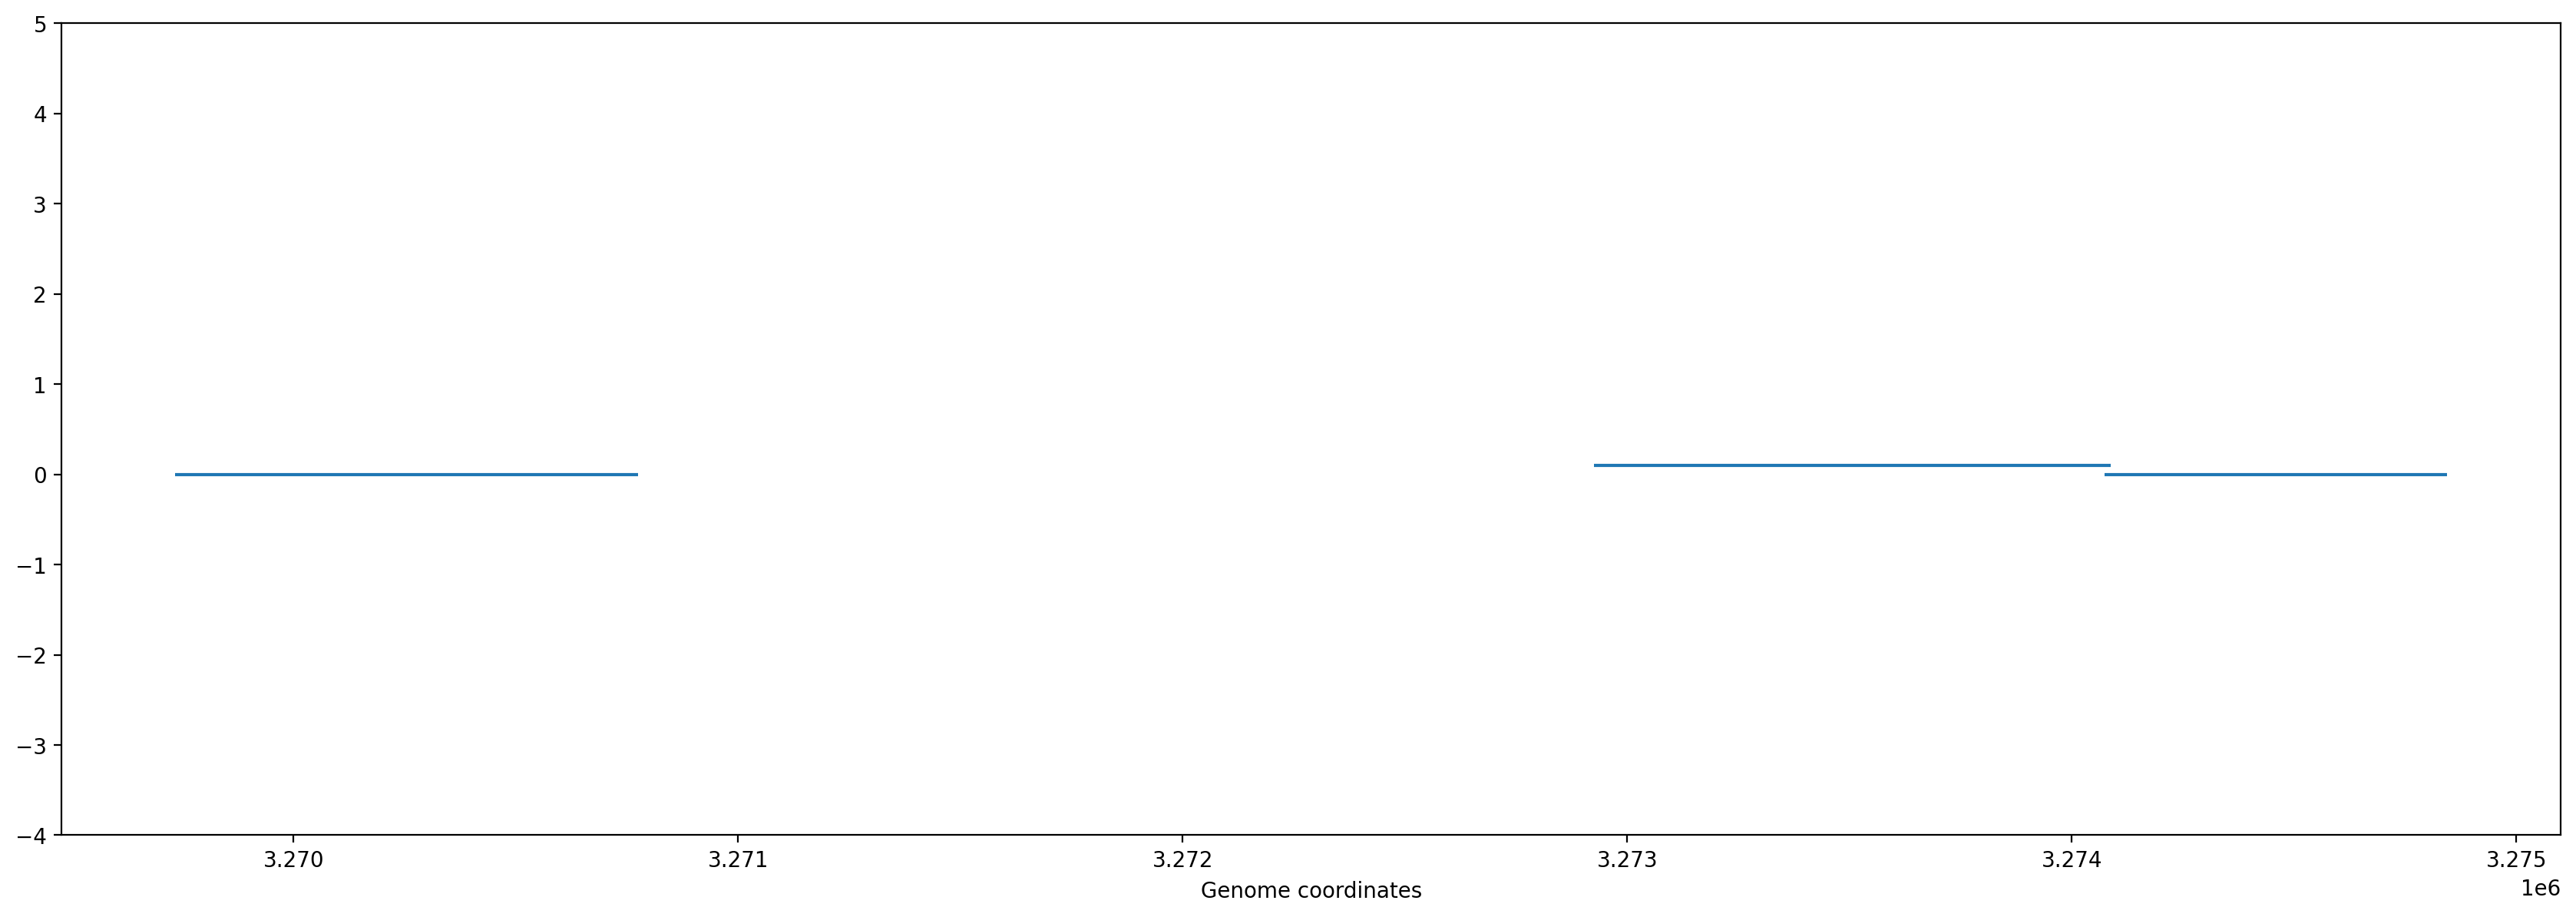

In [138]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(21, 7), dpi=200)
for i, feature in enumerate(target_features):
    ax.hlines(i % 2 / 10, feature.location.start, feature.location.end)
    ax.set_ylim(-4, 5)
    ax.set_xlabel('Genome coordinates')

Есть один одиночный ген и оперон

### 5

In [157]:
dist_matrix = np.zeros((10, 10), dtype=np.float64)
for sequence_id_1 in blocks_by_sample[1000].keys():
    for sequence_id_2 in blocks_by_sample[1000].keys():
        if sequence_id_1 == sequence_id_2:
            continue
        else:
            dist_matrix[sequence_id_1 - 1, sequence_id_2 - 1] = len(
                blocks_by_sample[1000][sequence_id_1].intersection(blocks_by_sample[1000][sequence_id_2])
            )
dist_matrix[np.arange(0, 10), np.arange(0, 10)] = np.mean(dist_matrix[dist_matrix != 0])

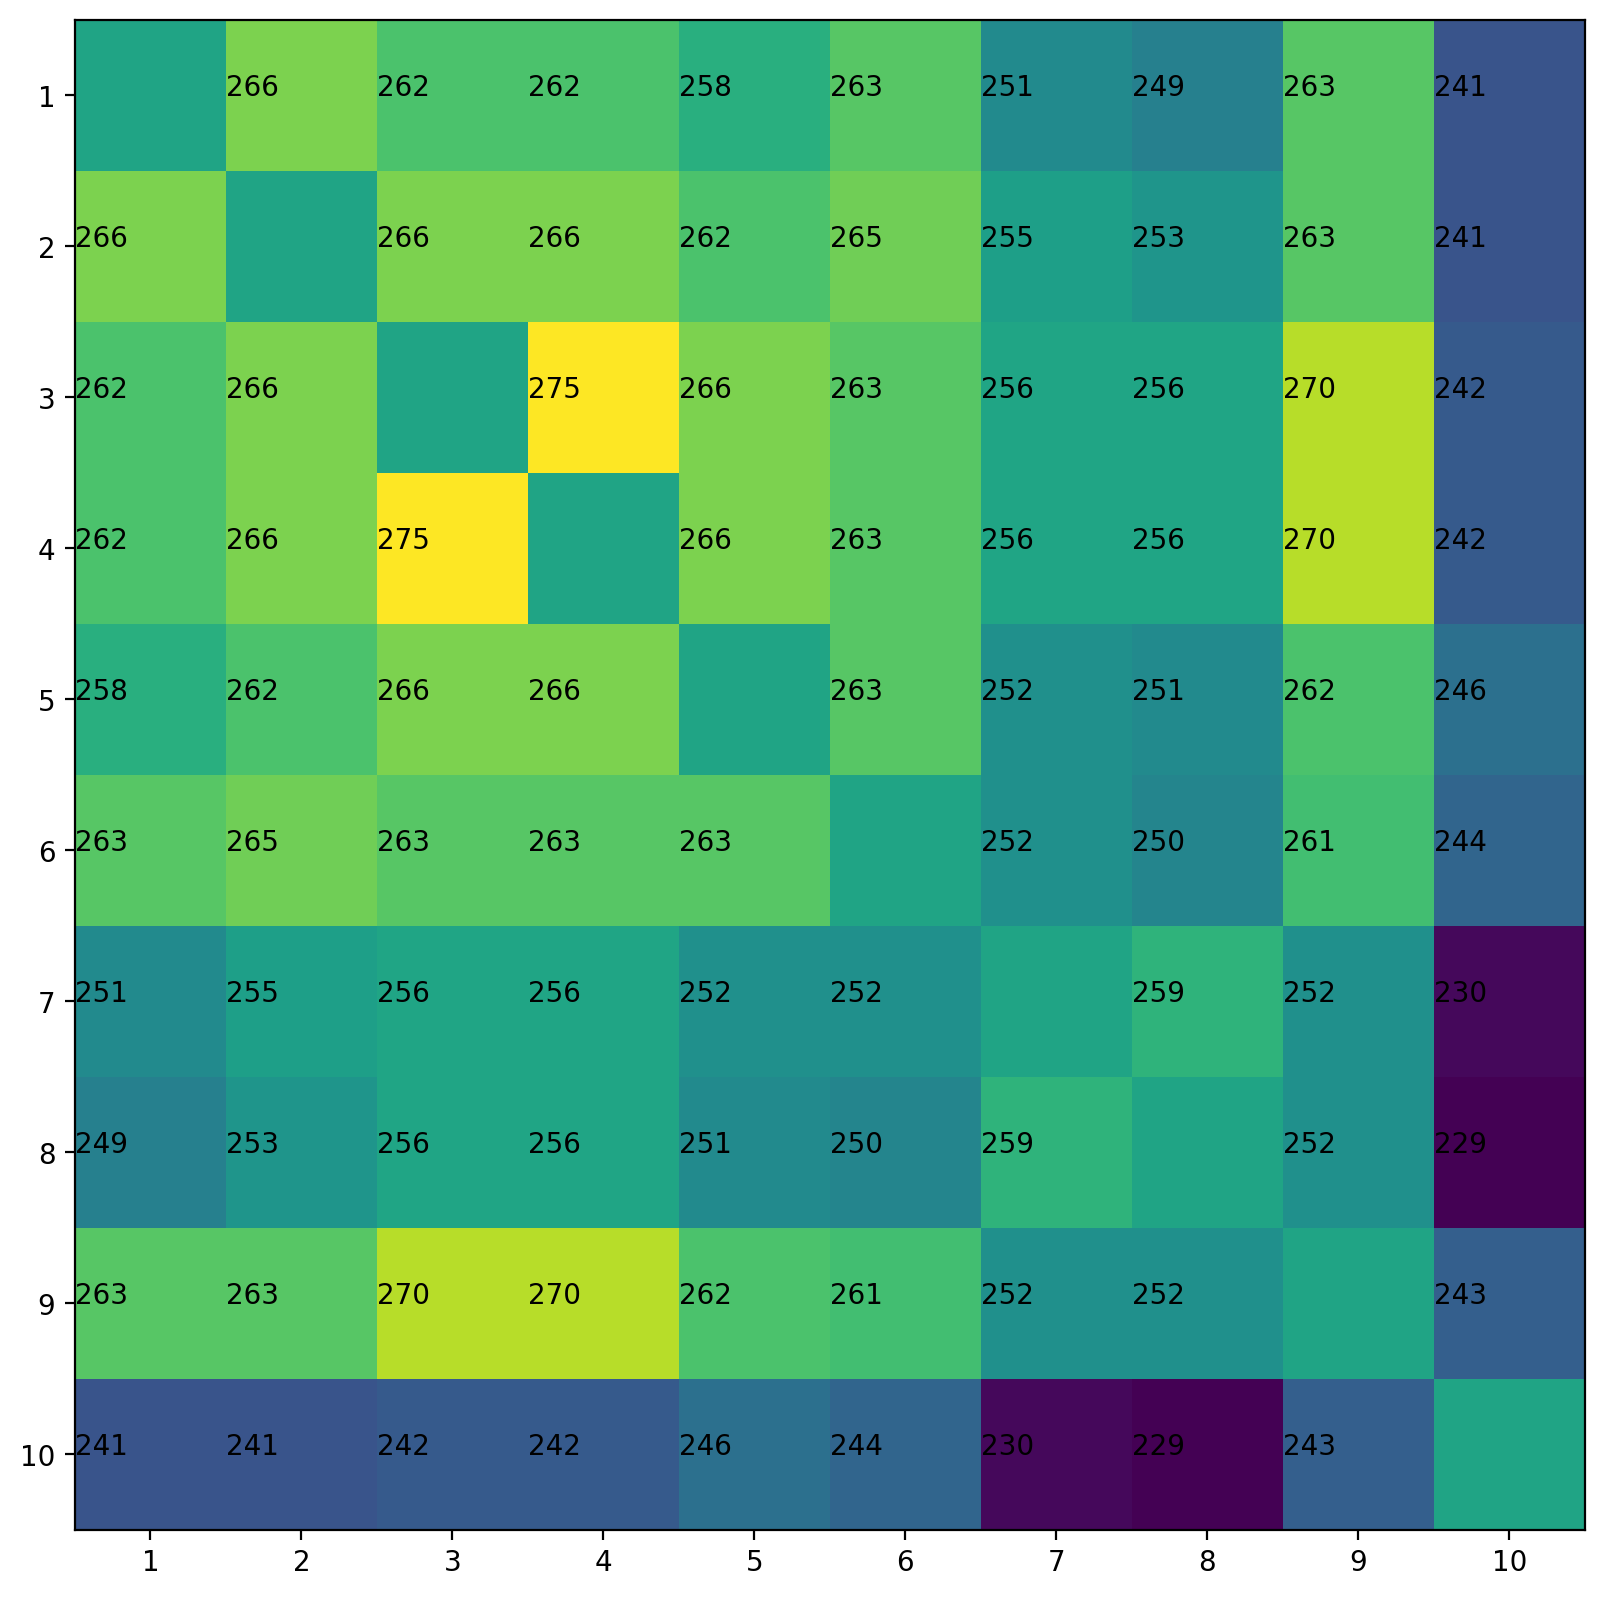

In [166]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=200)
ax.imshow(dist_matrix)
ax.set_xticks(range(10))
ax.set_xticklabels(list(range(1, 11)))
ax.set_yticks(range(10))
ax.set_yticklabels(list(range(1, 11)))
for i in range(10):
    for j in range(10):
        if i != j:
            ax.text(i - 0.5, j, f"{dist_matrix[i, j]:.0f}")

### 6

according to previous plot - 10 (ASM83500v1) and 8 (ASM118893v1) are most distant genomes

yass dotplot:

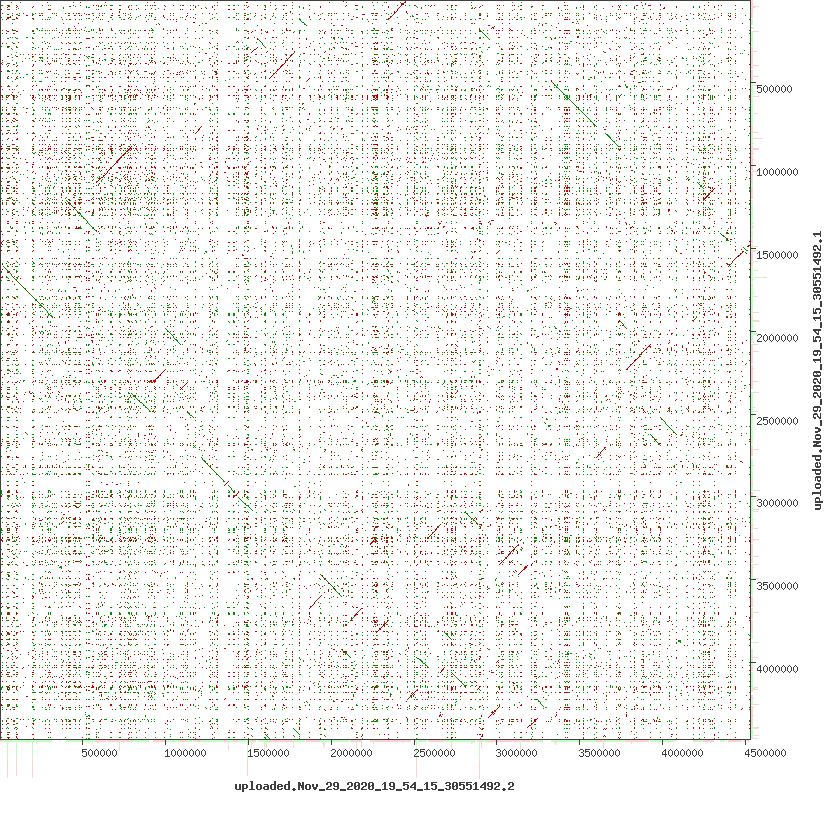

In [171]:
subprocess.run([
    'Sibelia-2.1.1-Darwin/bin/Sibelia',
    '-a',
    '-s',
    'fine',
    '-m',
    '1000',
    '-o', 
    '1000min_pair_sibelia_result',
    'ASM83500v1-no-plasmids.fna',
    'ASM118893v1-no-plasmids.fna'
], check=True)

CompletedProcess(args=['Sibelia-2.1.1-Darwin/bin/Sibelia', '-a', '-s', 'fine', '-m', '1000', '-o', '1000min_pair_sibelia_result', 'ASM83500v1-no-plasmids.fna', 'ASM118893v1-no-plasmids.fna'], returncode=0)

longest inversion:

In [178]:
"""
	-12	
	20	
	-38	
	77	
	85	
	47	
	35	
	23	
	-39	
	-13	
	-51	
	30	
	-46	
	-87	
	-14	
	-76	
	-60	
	29	
	-63	
	-70	
	72	
	-50	
	-17	
	-65	
	-83	
	-10	
	25	
	-81	
	-42	
	-62	
	45	
	-88	
	-41	
	32	
	-82	
	-28	
	-86	
	-37	
	-22	
	-24	
	-33	
	16	
	-75	
	-48	
	-1	
	11	
	-19	
	-21	
	58	
	-15	
	-71	
	43	
	-3	
	-9	
	-79	
	-2	
	-56	
	57	
	36	
	73	
	-84	
	67	
	-64	
	5	
	7	
	-26	
	-18	""".count('\n')

67

In [179]:
pair_blocks_data = parse_blocks_data('1000min_pair_sibelia_result/blocks_coords.txt')

In [180]:
pair_blocks_data['block_hits'][18]

,Strand,Start,End,Length
Seq_id,,,,
1,-,3817389,3746151,71239
2,+,2273785,2342770,68986


In [181]:
pair_blocks_data['block_hits'][12]

,Strand,Start,End,Length
Seq_id,,,,
1,+,3193047,3245517,52471
2,-,2635342,2585009,50334


In [184]:
repeat_masker_result = """
   12   13.7  6.2  0.0  CP010293.1    20390   20421 (4542648) + (CACTAT)n      Simple_repeat          1     34    (0)   1  
   12   14.8  4.9  4.9  CP010293.1    46395   46435 (4516634) + (ACCTC)n       Simple_repeat          1     41    (0)   2  
   13   14.8  2.3  7.3  CP010293.1   152820  152862 (4410207) + A-rich         Low_complexity         1     41    (0)   3  
   13   28.4  3.3  1.6  CP010293.1   178841  178901 (4384168) + A-rich         Low_complexity         1     62    (0)   4  
  584   30.0  6.1  3.5  CP010293.1   191096  191454 (4371615) + SSU-rRNA_Hsa   rRNA                1025   1392  (477)   5  
  301   32.1  0.0  0.0  CP010293.1   191644  191749 (4371320) + SSU-rRNA_Hsa   rRNA                1605   1710  (159)   5  
  253   11.6  0.0  0.0  CP010293.1   191832  191874 (4371195) + SSU-rRNA_Hsa   rRNA                1824   1866    (3)   6  
  359   22.4  0.0  1.9  CP010293.1   192519  192627 (4370442) + LSU-rRNA_Hsa   rRNA                  17    123 (4912)   7  
  328   22.4  2.0  3.0  CP010293.1   192765  192865 (4370204) + LSU-rRNA_Hsa   rRNA                 316    415 (4620)   7  
  244   29.2  3.3  2.6  CP010293.1   193014  193164 (4369905) + LSU-rRNA_Hsa   rRNA                1504   1655 (3380)   7  
  438   29.8  4.7 10.2  CP010293.1   194118  194479 (4368590) + LSU-rRNA_Hsa   rRNA                3612   3955 (1080)   7  
  469   30.1  5.0  4.7  CP010293.1   194570  194952 (4368117) + LSU-rRNA_Hsa   rRNA                4136   4519  (516)   7  
  239   26.2  0.0  1.5  CP010293.1   195497  195562 (4367507) + tRNA-Ala-GCG   tRNA                   4     68    (4)   8  
   14    9.3  0.0  0.0  CP010293.1   209959  209981 (4353088) + (GTG)n         Simple_repeat          1     23    (0)   9  
   16   15.5  7.7  1.8  CP010293.1   240461  240512 (4322557) + (GCTTCC)n      Simple_repeat          1     55    (0)  10  
   12   19.7  0.0  0.0  CP010293.1   253402  253430 (4309639) + (TCA)n         Simple_repeat          1     29    (0)  11  
   15   18.4  4.7  0.0  CP010293.1   264975  265017 (4298052) + (TTACTGC)n     Simple_repeat          1     45    (0)  12  
  584   30.0  6.1  3.5  CP010293.1   315106  315464 (4247605) + SSU-rRNA_Hsa   rRNA                1025   1392  (477)  13  
  301   32.1  0.0  0.0  CP010293.1   315654  315759 (4247310) + SSU-rRNA_Hsa   rRNA                1605   1710  (159)  13  
  253   11.6  0.0  0.0  CP010293.1   315842  315884 (4247185) + SSU-rRNA_Hsa   rRNA                1824   1866    (3)  14  
  359   22.4  0.0  1.9  CP010293.1   316529  316637 (4246432) + LSU-rRNA_Hsa   rRNA                  17    123 (4912)  15  
  328   22.4  2.0  3.0  CP010293.1   316775  316875 (4246194) + LSU-rRNA_Hsa   rRNA                 316    415 (4620)  15  
  244   29.2  3.3  2.6  CP010293.1   317024  317174 (4245895) + LSU-rRNA_Hsa   rRNA                1504   1655 (3380)  15  
  429   29.8  4.7 10.2  CP010293.1   318128  318489 (4244580) + LSU-rRNA_Hsa   rRNA                3612   3955 (1080)  15  
  469   30.1  5.0  4.7  CP010293.1   318580  318962 (4244107) + LSU-rRNA_Hsa   rRNA                4136   4519  (516)  15  
  180   27.1  1.4  1.4  CP010293.1   319609  319679 (4243390) + MamSINE1       SINE/tRNA-RTE          2     72  (218)  16  
  183   10.7  0.0  0.0  CP010293.1   373489  373516 (4189553) C L3             LINE/CR1          (2888)   1211   1184  17  
  243   27.7  1.3  3.9  CP010293.1   379799  379877 (4183192) + MamSINE1       SINE/tRNA-RTE         14     90  (200)  18  
  189   28.8  3.0  1.5  CP010293.1   379957  380023 (4183046) + MIR1_Amn       SINE/MIR              12     79  (151)  19  
   13   32.8  1.0  6.4  CP010293.1   386687  386785 (4176284) + (AATG)n        Simple_repeat          1     94    (0)  20  
   95    0.0  0.0  0.0  CP010293.1   429287  429370 (4133699) + (GAAGTTGAA)n   Simple_repeat          1     84    (0)  21  
  188    3.2  0.0  0.0  CP010293.1   441795  441983 (4121086) + (GATTAAC)n     Simple_repeat          1    189    (0)  22  
   14   10.7  3.1  3.1  CP010293.1   485344  485375 (4077694) + (ATAA)n        Simple_repeat          1     32    (0)  23  
   13    0.0 12.9  2.9  CP010293.1   491896  491926 (4071143) + (TGGTT)n       Simple_repeat          1     34    (0)  24  
   12   23.6  7.6  1.4  CP010293.1   510234  510299 (4052770) + (TTATAA)n      Simple_repeat          1     70    (0)  25  
   12   20.4  0.0  2.9  CP010293.1   511716  511751 (4051318) + (CTATAT)n      Simple_repeat          1     35    (0)  26  
   14   22.7  0.0  0.0  CP010293.1   521856  521891 (4041178) + (CCG)n         Simple_repeat          1     36    (0)  27  
  296   23.0  0.0  0.0  CP010293.1   529938  530013 (4033056) C tRNA-Tyr-TAC   tRNA                 (0)     76      1  28  
   12   19.8  2.3  4.7  CP010293.1   532668  532711 (4030358) + (GGTGT)n       Simple_repeat          1     43    (0)  29  
   12   18.1  0.0  3.1  CP010293.1   533124  533156 (4029913) + (AATT)n        Simple_repeat          1     32    (0)  30  
   12   18.4  0.0  3.1  CP010293.1   547220  547252 (4015817) + A-rich         Low_complexity         1     32    (0)  31  
  189   26.0 13.3  3.8  CP010293.1   600439  600558 (3962511) C X9_LINE        LINE/L1            (466)    470    340  32  
   11   21.6  0.0  5.1  CP010293.1   608744  608784 (3954285) + (TAATAAT)n     Simple_repeat          1     39    (0)  33  
   17   24.7  0.0  2.2  CP010293.1   680730  680776 (3882293) + (GTT)n         Simple_repeat          1     46    (0)  34  
   12    7.8  3.2  6.7  CP010293.1   681107  681137 (3881932) + (TCTGC)n       Simple_repeat          1     30    (0)  35  
   12   11.7  3.3  3.3  CP010293.1   716421  716450 (3846619) + (GATA)n        Simple_repeat          1     30    (0)  36  
   14   26.2  1.8  1.8  CP010293.1   767350  767405 (3795664) + A-rich         Low_complexity         1     56    (0)  37  
  268   30.9  0.0  0.0  CP010293.1   779181  779248 (3783821) C tRNA-Ile-ATC   tRNA                 (0)     75      8  38 
  348   22.4  0.0  0.0  CP010293.1   779190  779256 (3783813) C MamSINE1       SINE/tRNA-RTE      (218)     72      6  39  
  268   30.9  0.0  0.0  CP010293.1   779644  779711 (3783358) C tRNA-Ile-ATC   tRNA                 (0)     75      8  40 
  348   22.4  0.0  0.0  CP010293.1   779653  779719 (3783350) C MamSINE1       SINE/tRNA-RTE      (218)     72      6  41  
   29    0.0  0.0  0.0  CP010293.1   816555  816590 (3746479) + (TCACCTG)n     Simple_repeat          1     36    (0)  42  
   56    1.8  0.0  0.0  CP010293.1   816591  816645 (3746424) + (CACCTAC)n     Simple_repeat          1     55    (0)  43  
   12   28.2  4.9  1.6  CP010293.1   826798  826858 (3736211) + (TGACCA)n      Simple_repeat          1     63    (0)  44  
   12   22.6  4.8  0.0  CP010293.1   871090  871131 (3691938) + (ATTA)n        Simple_repeat          1     44    (0)  45  
   17   22.2  0.0  0.0  CP010293.1   902525  902566 (3660503) + A-rich         Low_complexity         1     42    (0)  46  
  192   25.9  7.3  1.1  CP010293.1   920973  921054 (3642015) C L3             LINE/CR1           (556)   3543   3457  47  
  180   23.0  2.0  6.1  CP010293.1   926160  926210 (3636859) + MIR            SINE/MIR               6     54  (208)  48  
   15   28.8  0.0  0.0  CP010293.1   951365  951406 (3611663) + (TA)n          Simple_repeat          1     42    (0)  49  
   87    0.0  0.0  0.0  CP010293.1   952792  952868 (3610201) + (TCACTGCG)n    Simple_repeat          1     77    (0)  50  
   13   18.8  0.0  0.0  CP010293.1   955060  955090 (3607979) + (GTGCTG)n      Simple_repeat          1     31    (0)  51  
  195   19.7 17.9  2.2  CP010293.1   957474  957551 (3605518) + OldhAT1        DNA/hAT-Ac           948   1037 (1805)  52  
   15   18.7  4.7  0.0  CP010293.1   959544  959586 (3603483) + (TATATT)n      Simple_repeat          1     45    (0)  53  
   12   13.2  0.0 10.8  CP010293.1   960462  960502 (3602567) + (TATTTA)n      Simple_repeat          1     37    (0)  54  
  180   22.1  4.7  8.1  CP010293.1   967148  967211 (3595858) C MamRTE1        LINE/RTE-BovB     (2927)    885    824  55  
   15   16.9  0.0  0.0  CP010293.1  1063552 1063584 (3499485) + (GGTTTT)n      Simple_repeat          1     33    (0)  56  
   15   19.4  7.5  0.0  CP010293.1  1120141 1120193 (3442876) + (TATTTA)n      Simple_repeat          1     57    (0)  57  
   14   19.5  6.5  3.1  CP010293.1  1147452 1147513 (3415556) + A-rich         Low_complexity         1     64    (0)  58  
   19   11.4  0.0  7.1  CP010293.1  1147665 1147709 (3415360) + (TATAGA)n      Simple_repeat          1     42    (0)  59  
  195   31.1  1.3  6.9  CP010293.1  1173844 1173919 (3389150) C X9_LINE        LINE/L1             (77)    859    788  60  
   27    0.0  0.0  0.0  CP010293.1  1179126 1179151 (3383918) + (AACA)n        Simple_repeat          1     26    (0)  61  
  183   19.7  0.0 24.1  CP010293.1  1179701 1179767 (3383302) + L3             LINE/CR1            3452   3505  (594)  62  
   92    0.0  0.0  0.0  CP010293.1  1188397 1188477 (3374592) + (TTGATTAG)n    Simple_repeat          1     81    (0)  63  
  184   26.6  3.2  8.9  CP010293.1  1203923 1204017 (3359052) C MamRTE1        LINE/RTE-BovB     (3406)    406    317  64  
   39    0.0  0.0  0.0  CP010293.1  1234914 1234949 (3328120) + (ACAGATG)n     Simple_repeat          1     36    (0)  65  
   15   15.8  0.0  5.4  CP010293.1  1235115 1235153 (3327916) + (CTGT)n        Simple_repeat          1     37    (0)  66  
   14   27.7  1.7  1.7  CP010293.1  1252491 1252548 (3310521) + A-rich         Low_complexity         1     58    (0)  67  
   15    4.5  0.0  4.2  CP010293.1  1253422 1253446 (3309623) + (GCA)n         Simple_repeat          1     24    (0)  68  
   39    4.2  2.0  0.0  CP010293.1  1260385 1260433 (3302636) + (TAGAGAAA)n    Simple_repeat          1     50    (0)  69  
   69    5.3  0.0  0.0  CP010293.1  1304134 1304213 (3258856) + (CAATAAGC)n    Simple_repeat          1     80    (0)  70  
   11   20.1  2.9  0.0  CP010293.1  1313077 1313110 (3249959) + (ACGACC)n      Simple_repeat          1     35    (0)  71  
   17   15.5  0.0  2.7  CP010293.1  1323384 1323421 (3239648) + (TGGCGG)n      Simple_repeat          1     37    (0)  72  
   15   23.7  0.0  5.8  CP010293.1  1323534 1323588 (3239481) + (ATTT)n        Simple_repeat          1     52    (0)  73  
   29    3.2  0.0  0.0  CP010293.1  1364982 1365013 (3198056) + (AAAACTG)n     Simple_repeat          1     32    (0)  74  
   12   16.5  0.0  0.0  CP010293.1  1382281 1382307 (3180762) + (TTTA)n        Simple_repeat          1     27    (0)  75  
  277   22.7  0.0  0.0  CP010293.1  1394327 1394392 (3168677) C tRNA-Tyr-TAC   tRNA                 (5)     69      4  76  
  308   21.3  0.0  1.3  CP010293.1  1397534 1397609 (3165460) + tRNA-Ala-GCY_v tRNA                   1     75    (0)  77  
   15   30.6  1.7  0.0  CP010293.1  1422529 1422588 (3140481) + (ATGATG)n      Simple_repeat          1     61    (0)  78  
   19   29.3  0.0  3.9  CP010293.1  1422671 1422750 (3140319) + (TCATGT)n      Simple_repeat          1     77    (0)  79  
  106    6.0  0.0  0.0  CP010293.1  1487109 1487232 (3075837) + (GGTGACA)n     Simple_repeat          1    124    (0)  80  
   23   31.9  0.0  0.0  CP010293.1  1512125 1512206 (3050863) + (CACAAC)n      Simple_repeat          1     82    (0)  81  
  180   19.1  7.1  0.0  CP010293.1  1530279 1530320 (3032749) C OldhAT1        DNA/hAT-Ac        (2335)    507    463  82  
  188   23.2 11.7  4.9  CP010293.1  1572873 1572949 (2990120) + Penelope1_Vert LINE/Penelope        771    852  (227)  83  
   15   21.1  0.0  0.0  CP010293.1  1589999 1590036 (2973033) + (CACAGG)n      Simple_repeat          1     38    (0)  84  
   11   29.4  0.0  2.3  CP010293.1  1595981 1596025 (2967044) + A-rich         Low_complexity         1     44    (0)  85  
   12   20.0  0.0  0.0  CP010293.1  1596191 1596219 (2966850) + (AATTT)n       Simple_repeat          1     29    (0)  86  
   17    5.4  7.1  4.7  CP010293.1  1658813 1658861 (2904208) + (ATCAAT)n      Simple_repeat          1     50    (0)  87  
  188   32.1  0.0  0.0  CP010293.1  1689595 1689650 (2873419) + MamSINE1       SINE/tRNA-RTE         14     69  (221)  88  
  185   35.6  2.1  3.3  CP010293.1  1689731 1689823 (2873246) + MamSINE1       SINE/tRNA-RTE         14    105  (185)  89  
  200   20.6  4.1 13.4  CP010293.1  1697849 1697921 (2865148) C OldhAT1        DNA/hAT-Ac        (2563)    279    213  90  
   12    4.7  0.0  8.3  CP010293.1  1758949 1758974 (2804095) + (TTAA)n        Simple_repeat          1     24    (0)  91  
   12   18.3  0.0  3.1  CP010293.1  1784536 1784568 (2778501) + (TATTGT)n      Simple_repeat          1     32    (0)  92  
   46    0.0  0.0  0.0  CP010293.1  1793870 1793911 (2769158) + (GATA)n        Simple_repeat          1     42    (0)  93  
   16    7.4  0.0  6.5  CP010293.1  1797112 1797153 (2765916) + (TCTTC)n       Simple_repeat          1     39    (0)  94  
   12   20.0  0.0  0.0  CP010293.1  1799072 1799100 (2763969) + (TCAA)n        Simple_repeat          1     29    (0)  95  
   15    0.0 16.7  0.0  CP010293.1  1812285 1812320 (2750749) + (TTACACA)n     Simple_repeat          1     42    (0)  96  
   15   31.0  0.0  1.7  CP010293.1  1834211 1834271 (2728798) + (TTAT)n        Simple_repeat          1     60    (0)  97  
   17   23.9  0.0  0.0  CP010293.1  1843422 1843466 (2719603) + (TCAACT)n      Simple_repeat          1     45    (0)  98  
   16   24.9  1.9  1.9  CP010293.1  1856752 1856805 (2706264) + (CATT)n        Simple_repeat          1     54    (0)  99  
  181   30.9  4.8  5.9  CP010293.1  1883570 1883672 (2679397) C OldhAT1        DNA/hAT-Ac        (1069)   1773   1672 100  
   18   25.1  0.0  7.1  CP010293.1  1929866 1929940 (2633129) + (ATA)n         Simple_repeat          1     70    (0) 101  
   52    0.0  0.0  0.0  CP010293.1  1930014 1930060 (2633009) + (TACACC)n      Simple_repeat          1     47    (0) 102  
   53    0.0  0.0  0.0  CP010293.1  1937367 1937414 (2625655) + (CTTTCTAT)n    Simple_repeat          1     48    (0) 103  
  185   22.5  0.0  6.1  CP010293.1  1990385 1990436 (2572633) + L3             LINE/CR1            2212   2260 (1839) 104  
   16   27.2  4.5  0.0  CP010293.1  2005519 2005584 (2557485) + (TTTAA)n       Simple_repeat          1     69    (0) 105  
  296   23.0  0.0  1.4  CP010293.1  2015505 2015579 (2547490) C tRNA-Lys-AAA   tRNA                 (0)     76      3 106  
   15    7.4  3.2  3.2  CP010293.1  2040716 2040746 (2522323) + (CCACCG)n      Simple_repeat          1     31    (0) 107  
  186   18.2  0.0  4.5  CP010293.1  2043936 2043981 (2519088) C L3b            LINE/CR1           (898)   4334   4291 108  
   12   10.8  6.7  0.0  CP010293.1  2051994 2052023 (2511046) + A-rich         Low_complexity         1     32    (0) 109  
   38    0.0  0.0  0.0  CP010293.1  2052248 2052282 (2510787) + (ATTACT)n      Simple_repeat          1     35    (0) 110  
  139    3.6  0.0  0.0  CP010293.1  2058126 2058268 (2504801) + (TCATTGT)n     Simple_repeat          1    143    (0) 111  
  307   21.5  1.5  0.0  CP010293.1  2095167 2095231 (2467838) + tRNA-Tyr-TAC   tRNA                   8     73    (1) 112  
   12   16.1  9.5  0.0  CP010293.1  2095510 2095551 (2467518) + (TATTAG)n      Simple_repeat          1     46    (0) 113  
   14   18.5  8.2  0.0  CP010293.1  2100585 2100633 (2462436) + (TTAATG)n      Simple_repeat          1     53    (0) 114  
  180   27.7  0.0  6.9  CP010293.1  2172045 2172106 (2390963) + L2             LINE/L2             1195   1252 (2167) 115  
   19   28.4  2.5  6.1  CP010293.1  2190815 2190933 (2372136) + (ATAA)n        Simple_repeat          1    115    (0) 116  
   14   21.1  2.6  0.0  CP010293.1  2191208 2191245 (2371824) + (AAT)n         Simple_repeat          1     39    (0) 117  
   14   14.4  5.0  2.4  CP010293.1  2193697 2193736 (2369333) + (TTAT)n        Simple_repeat          1     41    (0) 118  
   14   16.2  4.4  4.4  CP010293.1  2201620 2201664 (2361405) + (TTA)n         Simple_repeat          1     45    (0) 119  
   14    4.5  4.3  0.0  CP010293.1  2212587 2212609 (2350460) + (TAT)n         Simple_repeat          1     24    (0) 120  
   13   19.6  2.2  4.5  CP010293.1  2283789 2283833 (2279236) + (AATTTAA)n     Simple_repeat          1     44    (0) 121  
   13   21.2  2.1  4.3  CP010293.1  2314964 2315010 (2248059) + (AAGCC)n       Simple_repeat          1     46    (0) 122  
   20   29.0  0.0  0.0  CP010293.1  2367179 2367241 (2195828) + (TGGAAG)n      Simple_repeat          1     63    (0) 123  
   18   31.9  0.0  5.9  CP010293.1  2368210 2368316 (2194753) + (GGTGGA)n      Simple_repeat          1    101    (0) 124  
   42    0.0  0.0  0.0  CP010293.1  2415244 2415282 (2147787) + (AATACAGGA)n   Simple_repeat          1     39    (0) 125  
   13   12.7  0.0 10.5  CP010293.1  2420891 2420932 (2142137) + (ATGG)n        Simple_repeat          1     38    (0) 126  
   13   19.9  2.4  2.4  CP010293.1  2448290 2448331 (2114738) + (CATCAT)n      Simple_repeat          1     42    (0) 127  
  184   22.4  5.1  1.6  CP010293.1  2474028 2474086 (2088983) + X6A_LINE       LINE/CR1             132    192  (886) 128  
   12   25.9  0.0  2.4  CP010293.1  2474492 2474534 (2088535) + (GCGATG)n      Simple_repeat          1     42    (0) 129  
  195   25.4  1.1 17.1  CP010293.1  2492772 2492866 (2070203) C OldhAT1        DNA/hAT-Ac         (737)   2105   2024 130  
  268   23.2  0.0  0.0  CP010293.1  2493660 2493715 (2069354) C tRNA-Lys-AAG   tRNA                (15)     61      6 131  
  269   22.7  0.0  0.0  CP010293.1  2493755 2493820 (2069249) C tRNA-Tyr-TAC   tRNA                 (5)     69      4 132  
   13   12.7  8.9  2.1  CP010293.1  2510187 2510231 (2052838) + (GCGCTAT)n     Simple_repeat          1     48    (0) 133  
   12   15.8  0.0  3.5  CP010293.1  2561332 2561361 (2001708) + (AGC)n         Simple_repeat          1     29    (0) 134  
  272   21.5  0.0  0.0  CP010293.1  2594928 2594993 (1968076) + tRNA-Lys-AAG   tRNA                   4     69    (5) 135  
  182   25.6  0.0  0.0  CP010293.1  2599461 2599499 (1963570) C OldhAT1        DNA/hAT-Ac         (555)   2287   2249 136  
  237   26.8  0.0  0.0  CP010293.1  2601456 2601511 (1961558) + tRNA-Lys-AAG   tRNA                   8     63   (13) 137  
   43    0.0  0.0  0.0  CP010293.1  2604299 2604338 (1958731) + (CCTGATGTG)n   Simple_repeat          1     40    (0) 138  
  329   21.5  1.5  0.0  CP010293.1  2624192 2624256 (1938813) C tRNA-Tyr-TAC   tRNA                 (1)     73      8 139  
   12   11.6  3.3  3.3  CP010293.1  2632378 2632407 (1930662) + (TGAAG)n       Simple_repeat          1     30    (0) 140  
  195   16.1  7.9 11.5  CP010293.1  2653539 2653601 (1909468) + Tigger19b      DNA/TcMar-Tigger      12     72  (478) 141  
   20   16.5  4.1  0.0  CP010293.1  2667402 2667450 (1895619) + (ATTAACT)n     Simple_repeat          1     51    (0) 142  
   39    0.0  2.5  0.0  CP010293.1  2680390 2680429 (1882640) + (TTTTCTTGT)n   Simple_repeat          1     41    (0) 143  
   12   21.6  0.0  5.1  CP010293.1  2691714 2691754 (1871315) + A-rich         Low_complexity         1     39    (0) 144  
  186   32.0 14.5  5.5  CP010293.1  2712031 2712182 (1850887) C MIRc           SINE/MIR            (94)    174     10 145  
  180   27.1  1.4  1.4  CP010293.1  2712123 2712193 (1850876) C MamSINE1       SINE/tRNA-RTE      (218)     72      2 146 
  469   30.1  5.0  4.7  CP010293.1  2712840 2713222 (1849847) C LSU-rRNA_Hsa   rRNA               (516)   4519   4136 147  
  429   29.8  4.7 10.2  CP010293.1  2713313 2713674 (1849395) C LSU-rRNA_Hsa   rRNA              (1080)   3955   3612 147  
  244   29.2  3.3  2.6  CP010293.1  2714628 2714778 (1848291) C LSU-rRNA_Hsa   rRNA              (3380)   1655   1504 147  
  328   22.4  2.0  3.0  CP010293.1  2714927 2715027 (1848042) C LSU-rRNA_Hsa   rRNA              (4620)    415    316 147  
  359   22.4  0.0  1.9  CP010293.1  2715165 2715273 (1847796) C LSU-rRNA_Hsa   rRNA              (4912)    123     17 147  
  253   11.6  0.0  0.0  CP010293.1  2715918 2715960 (1847109) C SSU-rRNA_Hsa   rRNA                 (3)   1866   1824 148  
  301   32.1  0.0  0.0  CP010293.1  2716043 2716148 (1846921) C SSU-rRNA_Hsa   rRNA               (159)   1710   1605 149  
  584   30.0  6.1  3.5  CP010293.1  2716338 2716696 (1846373) C SSU-rRNA_Hsa   rRNA               (477)   1392   1025 149  
   45    8.4  0.0  0.0  CP010293.1  2781483 2781546 (1781523) + (TAGTTGGTGA)n  Simple_repeat          1     64    (0) 150  
   14   12.4  2.6  5.3  CP010293.1  2817255 2817293 (1745776) + (AATATAA)n     Simple_repeat          1     38    (0) 151  
   16   22.8  5.4  7.3  CP010293.1  2825221 2825332 (1737737) + (TTTATCA)n     Simple_repeat          1    110    (0) 152  
  262   11.5  7.7  6.1  CP010293.1  2846959 2847023 (1716046) C MamSINE1       SINE/tRNA-RTE      (212)     78     13 153  
   60    0.0  0.0  0.0  CP010293.1  2879351 2879404 (1683665) + (CAAATAG)n     Simple_repeat          1     54    (0) 154  
   16   23.6  0.9  4.6  CP010293.1  2883807 2883877 (1679192) + A-rich         Low_complexity         1     68    (0) 155  
   12   23.5  2.5  0.0  CP010293.1  2884447 2884486 (1678583) + (TTATTT)n      Simple_repeat          1     41    (0) 156  
   12   25.2  2.4  0.0  CP010293.1  2885484 2885525 (1677544) + (TTTTAAT)n     Simple_repeat          1     43    (0) 157  
   12   12.6  8.6  0.0  CP010293.1  2889649 2889683 (1673386) + (CATTAA)n      Simple_repeat          1     38    (0) 158  
  188   17.0  6.8 10.5  CP010293.1  2903336 2903394 (1659675) + OldhAT1        DNA/hAT-Ac           547    603 (2239) 159  
   14   13.2  2.9  2.9  CP010293.1  2913466 2913500 (1649569) + (TATTGC)n      Simple_repeat          1     35    (0) 160  
   11   19.2  5.9  3.9  CP010293.1  2951155 2951205 (1611864) + (ATGGAC)n      Simple_repeat          1     52    (0) 161  
   16   24.1  1.8  3.6  CP010293.1  2976061 2976117 (1586952) + (GTT)n         Simple_repeat          1     56    (0) 162  
   17   21.5  0.0  0.0  CP010293.1  2976633 2976675 (1586394) + (CTGTTG)n      Simple_repeat          1     43    (0) 163  
   12    6.8  9.1  2.9  CP010293.1  2988716 2988748 (1574321) + (ATTAG)n       Simple_repeat          1     35    (0) 164  
   16   10.5  3.2  0.0  CP010293.1  3007201 3007231 (1555838) + (TATT)n        Simple_repeat          1     32    (0) 165  
   14   25.0  3.9  0.0  CP010293.1  3007629 3007680 (1555389) + (ATATTA)n      Simple_repeat          1     54    (0) 166  
   17   29.2  0.0  7.5  CP010293.1  3050252 3050351 (1512718) + A-rich         Low_complexity         1     93    (0) 167  
   17   15.8  0.0  2.8  CP010293.1  3061748 3061784 (1501285) + (GTG)n         Simple_repeat          1     36    (0) 168  
  551   30.1  5.0  4.7  CP010293.1  3076693 3077075 (1485994) C LSU-rRNA_Hsa   rRNA               (516)   4519   4136 169  
  506   29.8  4.7 10.2  CP010293.1  3077166 3077527 (1485542) C LSU-rRNA_Hsa   rRNA              (1080)   3955   3612 169  
  277   31.1  2.6  2.0  CP010293.1  3078482 3078632 (1484437) C LSU-rRNA_Hsa   rRNA              (3380)   1655   1504 169  
  340   22.4  2.0  3.0  CP010293.1  3078781 3078881 (1484188) C LSU-rRNA_Hsa   rRNA              (4620)    415    316 170  
  376   22.4  0.0  1.9  CP010293.1  3079019 3079127 (1483942) C LSU-rRNA_Hsa   rRNA              (4912)    123     17 170  
  266   22.7  0.0  1.3  CP010293.1  3079518 3079593 (1483476) C tRNA-Ala-GCY_v tRNA                 (0)     75      1 171  
  229   31.1  0.0  0.0  CP010293.1  3079645 3079718 (1483351) C tRNA-Asn-AAC   tRNA                 (0)     77      4 172  
  259   11.6  0.0  0.0  CP010293.1  3079832 3079874 (1483195) C SSU-rRNA_Hsa   rRNA                 (3)   1866   1824 173  
  316   37.4  3.9  0.0  CP010293.1  3079958 3080160 (1482909) C SSU-rRNA_Hsa   rRNA               (159)   1710   1500 174  
  648   29.7  6.1  3.8  CP010293.1  3080253 3080612 (1482457) C SSU-rRNA_Hsa   rRNA               (477)   1392   1025 174  
   42    0.0  0.0  0.0  CP010293.1  3102949 3102987 (1460082) + (ACTCCCTG)n    Simple_repeat          1     39    (0) 175  
  229   20.8  0.0  3.8  CP010293.1  3126833 3126887 (1436182) + MADE1          DNA/TcMar-Mariner     23     75    (5) 176  
   23   11.1  0.0  0.0  CP010293.1  3150121 3150159 (1412910) + (TGAAC)n       Simple_repeat          1     39    (0) 177  
   15    4.7  0.0  0.0  CP010293.1  3165725 3165746 (1397323) + (AAAC)n        Simple_repeat          1     22    (0) 178  
  183   32.9  2.3  1.1  CP010293.1  3183912 3183997 (1379072) C L2             LINE/L2           (2048)   1371   1285 179  
   14   17.5  0.0  0.0  CP010293.1  3214772 3214803 (1348266) + (CCACCG)n      Simple_repeat          1     32    (0) 180  
   14   24.9  2.3  0.0  CP010293.1  3222151 3222193 (1340876) + (GAT)n         Simple_repeat          1     44    (0) 181  
   59    0.0  0.0  0.0  CP010293.1  3256387 3256439 (1306630) + (AGCAAAA)n     Simple_repeat          1     53    (0) 182  
   14   22.6  0.0  2.4  CP010293.1  3270073 3270115 (1292954) + (CATTTTT)n     Simple_repeat          1     42    (0) 183  
   42    0.0  0.0  0.0  CP010293.1  3342570 3342608 (1220461) + (GATGCAGA)n    Simple_repeat          1     39    (0) 184  
   13   28.4  1.4  4.5  CP010293.1  3358395 3358463 (1204606) + A-rich         Low_complexity         1     67    (0) 185  
   15   27.4  0.0  0.0  CP010293.1  3389680 3389727 (1173342) + (TACTAA)n      Simple_repeat          1     48    (0) 186  
   13   26.4  1.5  6.3  CP010293.1  3429672 3429737 (1133332) + (GAT)n         Simple_repeat          1     63    (0) 187  
  469   30.1  5.0  4.7  CP010293.1  3491703 3492085 (1070984) C LSU-rRNA_Hsa   rRNA               (516)   4519   4136 188  
  438   29.8  4.7 10.2  CP010293.1  3492176 3492537 (1070532) C LSU-rRNA_Hsa   rRNA              (1080)   3955   3612 188  
  244   29.2  3.3  2.6  CP010293.1  3493492 3493642 (1069427) C LSU-rRNA_Hsa   rRNA              (3380)   1655   1504 188  
  328   22.4  2.0  3.0  CP010293.1  3493791 3493891 (1069178) C LSU-rRNA_Hsa   rRNA              (4620)    415    316 188  
  359   22.4  0.0  1.9  CP010293.1  3494029 3494137 (1068932) C LSU-rRNA_Hsa   rRNA              (4912)    123     17 188  
  253   11.6  0.0  0.0  CP010293.1  3494782 3494824 (1068245) C SSU-rRNA_Hsa   rRNA                 (3)   1866   1824 189  
  301   32.1  0.0  0.0  CP010293.1  3494907 3495012 (1068057) C SSU-rRNA_Hsa   rRNA               (159)   1710   1605 190  
  584   30.0  6.1  3.5  CP010293.1  3495202 3495560 (1067509) C SSU-rRNA_Hsa   rRNA               (477)   1392   1025 190  
   12    7.0 10.0  0.0  CP010293.1  3506464 3506493 (1056576) + (CAATTT)n      Simple_repeat          1     33    (0) 191  
   13    6.5  8.8  2.8  CP010293.1  3530471 3530504 (1032565) + (TTAT)n        Simple_repeat          1     36    (0) 192  
   17   19.3  4.2  5.6  CP010293.1  3555551 3555622 (1007447) + (AACACCG)n     Simple_repeat          1     71    (0) 193  
   12   20.8  8.0  0.0  CP010293.1  3571659 3571708  (991361) + (TTTGTCG)n     Simple_repeat          1     54    (0) 194  
  197   23.1  2.6  0.0  CP010293.1  3678425 3678463  (884606) + MamTip2b       DNA/hAT-Tip100        82    121  (328) 195  
  180   20.0  3.9  3.9  CP010293.1  3687715 3687766  (875303) C L3             LINE/CR1            (64)   4035   3984 196  
   27    0.0  0.0  0.0  CP010293.1  3737953 3737978  (825091) + (TTGGTG)n      Simple_repeat          1     26    (0) 197  
  235   26.8  0.0  0.0  CP010293.1  3767661 3767716  (795353) C tRNA-Lys-AAG   tRNA                (13)     63      8 198  
  235   26.8  0.0  0.0  CP010293.1  3767828 3767883  (795186) C tRNA-Lys-AAG   tRNA                (13)     63      8 199  
  305   23.0  0.0  0.0  CP010293.1  3799742 3799817  (763252) + tRNA-Tyr-TAC   tRNA                   1     76    (0) 200  
   14   25.0  2.0  2.0  CP010293.1  3826048 3826096  (736973) + (TTA)n         Simple_repeat          1     49    (0) 201  
   20    6.9  0.0  0.0  CP010293.1  3827732 3827762  (735307) + (TTCAA)n       Simple_repeat          1     31    (0) 202  
   12   20.1  0.0  2.9  CP010293.1  3884980 3885015  (678054) + A-rich         Low_complexity         1     35    (0) 203  
   14   25.4  2.1  0.0  CP010293.1  3910816 3910862  (652207) + A-rich         Low_complexity         1     48    (0) 204  
   16    0.0  0.0 12.9  CP010293.1  3919130 3919164  (643905) + (TCGGT)n       Simple_repeat          1     31    (0) 205  
   17   14.9  7.4  1.8  CP010293.1  3920721 3920774  (642295) + (AACACCG)n     Simple_repeat          1     57    (0) 206  
   14   25.9  0.0  0.0  CP010293.1  3968627 3968668  (594401) + (CGACAA)n      Simple_repeat          1     42    (0) 207  
   56    0.0  0.0  0.0  CP010293.1  3988230 3988279  (574790) + (TGTTGGG)n     Simple_repeat          1     50    (0) 208  
   18   24.1  0.0  4.9  CP010293.1  3995024 3995087  (567982) + (TTAA)n        Simple_repeat          1     61    (0) 209  
   15   16.4  0.0  2.9  CP010293.1  4007601 4007636  (555433) + (TGATTA)n      Simple_repeat          1     35    (0) 210  
   14   16.1  0.0  0.0  CP010293.1  4017672 4017700  (545369) + (ATTG)n        Simple_repeat          1     29    (0) 211  
   15   19.9  2.5  0.0  CP010293.1  4039314 4039353  (523716) + (AACCAC)n      Simple_repeat          1     41    (0) 212  
   92    0.0  0.0  0.0  CP010293.1  4065058 4065138  (497931) + (CTGCTCAA)n    Simple_repeat          1     81    (0) 213  
   18   15.6  5.8  1.9  CP010293.1  4075694 4075745  (487324) + A-rich         Low_complexity         1     54    (0) 214  
   13    7.2  3.0  6.2  CP010293.1  4080197 4080229  (482840) + (CAGCGC)n      Simple_repeat          1     32    (0) 215  
   17   31.9  0.0  0.0  CP010293.1  4109159 4109220  (453849) + (GATGAA)n      Simple_repeat          1     62    (0) 216  
   17   22.1  7.3  0.0  CP010293.1  4119844 4119911  (443158) + (AGCTAA)n      Simple_repeat          1     73    (0) 217  
   12   18.1  0.0  3.1  CP010293.1  4124173 4124205  (438864) + (GCATTG)n      Simple_repeat          1     32    (0) 218  
   61    0.0  0.0  0.0  CP010293.1  4126141 4126195  (436874) + (TGCTGTAGA)n   Simple_repeat          1     55    (0) 219  
   16   14.8  4.1  4.1  CP010293.1  4131273 4131321  (431748) + (TTTGCTC)n     Simple_repeat          1     49    (0) 220  
   16   23.4  0.0  4.2  CP010293.1  4135533 4135582  (427487) + (TTAA)n        Simple_repeat          1     48    (0) 221  
  211   16.7  0.0  6.2  CP010293.1  4150230 4150280  (412789) + X15_LINE       LINE/L2              314    361    (0) 222  
   14   22.5  1.8  5.5  CP010293.1  4150482 4150569  (412500) + (TTAATT)n      Simple_repeat          1     84    (0) 223  
   15   18.8  7.1  1.7  CP010293.1  4180556 4180611  (382458) + (TCGTCA)n      Simple_repeat          1     59    (0) 224  
   13   25.1  2.0  2.0  CP010293.1  4181077 4181125  (381944) + (ATATTT)n      Simple_repeat          1     49    (0) 225  
   19   29.8  1.5  0.0  CP010293.1  4195192 4195257  (367812) + (ATC)n         Simple_repeat          1     67    (0) 226  
   18   17.9  0.0  4.3  CP010293.1  4196965 4197012  (366057) + (TTTTGA)n      Simple_repeat          1     46    (0) 227  
  184   28.4  1.6  3.3  CP010293.1  4229180 4229241  (333828) C MER5A          DNA/hAT-Charlie     (39)    150     90 228  
  218   17.9  0.0  7.1  CP010293.1  4243960 4244019  (319050) C OldhAT1        DNA/hAT-Ac         (226)   2616   2561 229  
   19   25.8  0.0  0.0  CP010293.1  4244652 4244703  (318366) + (ATCAGC)n      Simple_repeat          1     52    (0) 230  
   12   27.6  2.0  2.0  CP010293.1  4250768 4250817  (312252) + (ATA)n         Simple_repeat          1     50    (0) 231  
   13   16.8  0.0  5.7  CP010293.1  4264120 4264156  (298913) + (TTTAT)n       Simple_repeat          1     35    (0) 232  
   41    0.0  0.0  0.0  CP010293.1  4266372 4266409  (296660) + (TTATAGCGT)n   Simple_repeat          1     38    (0) 233  
   13   13.2  0.0  0.0  CP010293.1  4333609 4333633  (229436) + (GCA)n         Simple_repeat          1     25    (0) 234  
   11   21.9  9.3  0.0  CP010293.1  4345593 4345646  (217423) + (AGCAAT)n      Simple_repeat          1     59    (0) 235  
  225   18.2  0.0  3.6  CP010293.1  4345719 4345775  (217294) + L1PREC2        LINE/L1             4040   4094 (4061) 236  
   16   26.5  1.8  1.8  CP010293.1  4364107 4364162  (198907) + GA-rich        Low_complexity         1     56    (0) 237  
  279   23.0  1.3  1.3  CP010293.1  4365574 4365648  (197421) + tRNA-Ile-ATT   tRNA                   1     75    (0) 238  
  596   29.8  5.8  5.5  CP010293.1  4399576 4400026  (163043) C LSU-rRNA_Hsa   rRNA               (448)   4587   4136 239  
  552   33.1  2.8  8.1  CP010293.1  4400117 4400478  (162591) C LSU-rRNA_Hsa   rRNA              (1080)   3955   3612 239  
  299   31.1  2.6  2.0  CP010293.1  4401432 4401582  (161487) C LSU-rRNA_Hsa   rRNA              (3380)   1655   1504 239  
  350   22.4  2.0  3.0  CP010293.1  4401731 4401831  (161238) C LSU-rRNA_Hsa   rRNA              (4620)    415    316 240  
  405   23.4  0.0  1.8  CP010293.1  4401969 4402081  (160988) C LSU-rRNA_Hsa   rRNA              (4912)    123     13 240  
  283   22.7  0.0  1.3  CP010293.1  4402468 4402543  (160526) C tRNA-Ala-GCY_v tRNA                 (0)     75      1 241  
  244   31.1  0.0  0.0  CP010293.1  4402595 4402668  (160401) C tRNA-Asn-AAC   tRNA                 (0)     77      4 242  
  262   11.6  0.0  0.0  CP010293.1  4402782 4402824  (160245) C SSU-rRNA_Hsa   rRNA                 (3)   1866   1824 243  
  838   34.0  7.5  2.5  CP010293.1  4402907 4403560  (159509) C SSU-rRNA_Hsa   rRNA               (159)   1710   1025 244  
   14   17.6  0.0  0.0  CP010293.1  4416310 4416341  (146728) + (GCACAA)n      Simple_repeat          1     32    (0) 245  
   22   17.9  0.0  0.0  CP010293.1  4430061 4430104  (132965) + (GCA)n         Simple_repeat          1     44    (0) 246  
  330   25.0  0.0  0.0  CP010293.1  4435348 4435423  (127646) C tRNA-Lys-AAA   tRNA                 (0)     76      1 247  
  596   29.8  5.8  5.5  CP010293.1  4442440 4442890  (120179) C LSU-rRNA_Hsa   rRNA               (448)   4587   4136 248  
  552   33.1  2.8  8.1  CP010293.1  4442981 4443342  (119727) C LSU-rRNA_Hsa   rRNA              (1080)   3955   3612 248  
  299   31.1  2.6  2.0  CP010293.1  4444296 4444446  (118623) C LSU-rRNA_Hsa   rRNA              (3380)   1655   1504 248  
  350   22.4  2.0  3.0  CP010293.1  4444595 4444695  (118374) C LSU-rRNA_Hsa   rRNA              (4620)    415    316 249  
  405   23.4  0.0  1.8  CP010293.1  4444833 4444945  (118124) C LSU-rRNA_Hsa   rRNA              (4912)    123     13 249  
  283   22.7  0.0  1.3  CP010293.1  4445332 4445407  (117662) C tRNA-Ala-GCY_v tRNA                 (0)     75      1 250  
  244   31.1  0.0  0.0  CP010293.1  4445459 4445532  (117537) C tRNA-Asn-AAC   tRNA                 (0)     77      4 251  
  262   11.6  0.0  0.0  CP010293.1  4445646 4445688  (117381) C SSU-rRNA_Hsa   rRNA                 (3)   1866   1824 252  
  838   34.0  7.5  2.5  CP010293.1  4445771 4446424  (116645) C SSU-rRNA_Hsa   rRNA               (159)   1710   1025 253  
   12   24.1  2.2  2.2  CP010293.1  4456051 4456096  (106973) + (CACATA)n      Simple_repeat          1     46    (0) 254  """

In [188]:
repeat_masker_data = pd.read_csv(io.StringIO(repeat_masker_result), sep=' +', header=None, engine='python')

In [194]:
target_repeats = list()
minus_coordinates = [3817389, 3746151]
for _, row in repeat_masker_data.loc[repeat_masker_data[8] == 'C'].iterrows():
    if any(coordinate + 100000 > row[5] > coordinate - 100000 for coordinate in minus_coordinates):
        target_repeats.append(row)
plus_coordinates = [3193047, 3245517]
for _, row in repeat_masker_data.loc[repeat_masker_data[8] == '+'].iterrows():
    if any(coordinate + 100000 > row[5] > coordinate - 100000 for coordinate in plus_coordinates):
        target_repeats.append(row)

In [197]:
pd.DataFrame(target_repeats)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
219,180,20.0,3.9,3.9,CP010293.1,3687715,3687766,(875303),C,L3,LINE/CR1,(64),4035,3984,196
221,235,26.8,0.0,0.0,CP010293.1,3767661,3767716,(795353),C,tRNA-Lys-AAG,tRNA,(13),63,8,198
222,235,26.8,0.0,0.0,CP010293.1,3767828,3767883,(795186),C,tRNA-Lys-AAG,tRNA,(13),63,8,199
193,42,0.0,0.0,0.0,CP010293.1,3102949,3102987,(1460082),+,(ACTCCCTG)n,Simple_repeat,1,39,(0),175
194,229,20.8,0.0,3.8,CP010293.1,3126833,3126887,(1436182),+,MADE1,DNA/TcMar-Mariner,23,75,(5),176
195,23,11.1,0.0,0.0,CP010293.1,3150121,3150159,(1412910),+,(TGAAC)n,Simple_repeat,1,39,(0),177
196,15,4.7,0.0,0.0,CP010293.1,3165725,3165746,(1397323),+,(AAAC)n,Simple_repeat,1,22,(0),178
198,14,17.5,0.0,0.0,CP010293.1,3214772,3214803,(1348266),+,(CCACCG)n,Simple_repeat,1,32,(0),180
199,14,24.9,2.3,0.0,CP010293.1,3222151,3222193,(1340876),+,(GAT)n,Simple_repeat,1,44,(0),181
200,59,0.0,0.0,0.0,CP010293.1,3256387,3256439,(1306630),+,(AGCAAAA)n,Simple_repeat,1,53,(0),182


Рядом с блоком 18 нет интересующий повторов (комплиментарная цепь, C в столбце 8=), но рядом с блоком 12 есть несколько кандидатов